In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

*** Earth Engine *** FINAL DEADLINE: ee.Authenticate will fail after 2022-06-06. Please upgrade. https://developers.google.com/earth-engine/guides/python_install


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [3]:
# 定义参数
year = '2020'
startDate = year + '-01-01'
endDate = year + '-12-31'

In [4]:
# 定义参数
# region = 'daqing'
# sample_region = 'DAQING'
# region = 'tianjin'
# sample_region = 'TIANJIN'
# region = 'wuhan'
# sample_region = 'WUHAN'
# region = 'prd'
# sample_region = 'PRD'
region = 'tibet'
sample_region = 'TIBET'

In [5]:
# # 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# # 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# # 武汉市
# roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# # 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,7)

In [6]:
## 指数的计算
def water_index(img):
    image = img.clip(roi)
    ndvi=image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    ndwi=image.normalizedDifference(['B3', 'B5']).rename("NDWI")
    mndwi=image.normalizedDifference(['B3', 'B6']).rename("mNDWI")
    ndvi_mndwi = ndvi.subtract(mndwi).rename('ndvi_mndwi')
    cwi=image.select('B3').divide(image.select('B6')).rename("CWI")
    awei = image.expression('(B2 + 2.5*B3 - 1.5*(B5+B6) - 0.25*B7)/10000',
        {
          'B2': image.select('B2'),
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
          'B7': image.select('B7'),
        }).rename('AWEI')
    ewi = image.expression('(B3 - B5 - B6)/(B3 + B5 + B6)',
        {
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
        }).rename('EWI')
    evi = image.expression('2.5*(B5 - B4)/(B5 + 6*B4 - 7.5*B2 + 1)',
        {
          'B2': image.select('B2'),
          'B4': image.select('B4'),
          'B5': image.select('B5'),    
        }).rename('EVI')
    return image.addBands(ndvi).addBands(ndwi).addBands(mndwi).addBands(cwi).addBands(awei).addBands(ewi).addBands(evi).addBands(ndvi_mndwi)

elevation = ee.Image("users/311605001111/hillshade_" + region)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True)).updateMask(outlier)

def maskSR_reverse(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    image_cloud = img.updateMask(mask.remap([0,1],[1,0]))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image_shadow = img.updateMask(ee.Terrain.hillshade(elevation,azimuth,zenith).remap([0,1],[1,0]))
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    image_outlier = img.updateMask(bands.gt(0).rename('outlier'))
    return ee.ImageCollection([image_cloud,image_shadow,image_outlier]).sum()

# 图像可视化参数
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}

# 数据集

In [7]:
# l5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
#        .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
#        .filterBounds(roi) \
#        .filterDate(startDate, endDate)
# l7 = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR') \
#        .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
#        .filterBounds(roi) \
#        .filterDate(startDate, endDate)
# l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
#        .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
#        .filterBounds(roi) \
#        .filterDate(startDate, endDate) 
# landsat_image = l8.merge(l7).merge(l5).map(water_index)
# Map.addLayer(l8.map(maskSR).median().clip(roi), visParams,'image mosaic')
# print(l5.size().getInfo())
# print(l7.size().getInfo())
# print(l8.size().getInfo())
# print(landsat_image.size().getInfo())

# k-mean聚类，RF训练

In [8]:
# # # 加载样本集,PearlRiverDeltanew2020_l78,TibetPlateau_new2020_l78,daqing_new2020_l78,tianjin_new2020_l78,wuhan_new2020_l78
# samples = ee.FeatureCollection('users/311605001111/wuhan_tibetan/tibetan_2020')
# print("初始的样本数： ",samples.size().getInfo())
# bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
# # cluster与waterclass的对比
# def Compare(feature):
#     cluster = ee.Number(feature.get('cluster'))
#     waterclass = ee.Number(feature.get('waterclass'))
#     ft = ee.Algorithms.If(cluster.eq(waterclass),feature.set({'eq':1}),feature.set({'eq':0}))
#     return ft
# # k-mean聚类
# def k_mean(sampleSET):
#     clusterer = ee.Clusterer.wekaKMeans(2).train(sampleSET,bands)
#     result = sampleSET.cluster(clusterer)
#     right = result.map(Compare).filter(ee.Filter.eq('eq',0))
#     error = result.map(Compare).filter(ee.Filter.eq('eq',1))
#     filtered_sample = ee.FeatureCollection(ee.Algorithms.If(right.size().gt(error.size()),right,error))
#     return filtered_sample

# filtered_samples = k_mean(samples)
# print("筛选后，剩余的样本数： ",filtered_samples.size().getInfo())

# # RandomForest预测使用的波段，分类标签
# label = 'waterclass'
# bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']

# trainedClassifier = ee.Classifier.smileRandomForest(20).train(filtered_samples,label,bands)

In [9]:
totalSamples = ee.FeatureCollection('users/311605001111/SAMPLE_' + sample_region + '/' + region + '_kmean100_9920' + '_v2')
print("总的样本数： ",totalSamples.size().getInfo())

label = 'waterclass'
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7','NDVI','NDWI','mNDWI','CWI','AWEI','EWI','EVI']
trainedClassifier = ee.Classifier.smileRandomForest(150).train(totalSamples,label,bands)

总的样本数：  18445


# 图像分类

In [10]:
# basemap = ee.Image.constant(0).toFloat().updateMask(img.select('pixel_qa').gt(0)).rename('waterclass')
# img指经过指数计算，但未做云掩膜的图像
def classified_image(img):
    image = maskSR(img).select(bands).classify(trainedClassifier).eq(1).remap([0,1],[1,2]).rename('waterclass').float()
    invalidPixel = maskSR_reverse(img).select('pixel_qa').gt(0).remap([0,1],[1,0]).rename('waterclass').float()
    class_image = ee.ImageCollection([invalidPixel,image]).sum()
    invalidPixels = class_image.eq(0).multiply(ee.Image.pixelArea()).divide(1e6)
    invalidarea = invalidPixels.reduceRegion(**{'reducer': ee.Reducer.sum(),'geometry': roi,'scale': 200,'maxPixels': 1e14,'tileScale': 2}).get('waterclass')
    region = class_image.gte(0).multiply(ee.Image.pixelArea()).divide(1e6)
    regionarea = region.reduceRegion(**{'reducer': ee.Reducer.sum(),'geometry': roi,'scale': 200,'maxPixels': 1e14,'tileScale': 2}).get('waterclass')
    rate = ee.Number(invalidarea).divide(ee.Number(regionarea)).multiply(100)
    return class_image.set({'system:id':img.get('system:id')}).set({'CLOUD_COVER':img.get('CLOUD_COVER')}).set({'invalid_percentage':rate})

def waterArea(image):
    classified_image = image.select('waterclass').eq(2).rename('waterclass')
    water_area = classified_image.multiply(ee.Image.pixelArea()).divide(1e6)
    waterarea = water_area.reduceRegion(**{
        'reducer': ee.Reducer.sum(),
        'geometry': roi,
        'scale': 200,
        'maxPixels': 1e14,
        'tileScale': 2,
    })
    return image.set({'waterarea': waterarea.get('waterclass')})  

# 校正

## 计算“频率阈值”

In [11]:
# img指经过指数计算，但未做云掩膜的图像
def occurrence_Histogram(class_image):
    water = class_image.eq(2).selfMask()
    no_data = class_image.eq(0).selfMask()
    occurrence = ee.Image('JRC/GSW1_3/GlobalSurfaceWater').select('occurrence')
    occurrence_water = occurrence.updateMask(water)
    occurrence_no_data = occurrence.updateMask(no_data)
    occurrence_HistogramCount = occurrence_water.reduceRegion(**{
        'reducer': ee.Reducer.histogram(100,1),
        'geometry': roi,
        'scale': 30,
        'bestEffort': True,
        'tileScale': 2,
    })
    return class_image.set({'occurrence_HistogramCount': occurrence_HistogramCount.get('occurrence')})

# img指经过指数计算，但未做云掩膜的图像
def AutomaticCorrection_threshold(class_image):
    histogram = ee.List(ee.Dictionary(class_image.get('occurrence_HistogramCount')).get('histogram'))
    bucketMeans = ee.List(ee.Dictionary(class_image.get('occurrence_HistogramCount')).get('bucketMeans'))
    count_threshold = ee.Number(histogram.reduce(ee.Reducer.sum())).multiply(0.0017)
    index = histogram.map(lambda i : ee.Algorithms.If(ee.Number(i).gte(ee.Number(count_threshold)),ee.Number(i))).removeAll([None]).get(0)
    occurrence_threshold = bucketMeans.get(histogram.indexOf(index))
    return class_image.set({'occurrence_threshold':occurrence_threshold})

## 校正

In [12]:
# img指经过指数计算(需要校正的图像)，但未做云掩膜的图像
def AutomaticCorrection_enhanced(class_image):
    basemap = ee.Image.constant(0).toFloat().updateMask(class_image.gte(0)).rename('waterclass')
    water = class_image.eq(2).selfMask()
    occurrence = ee.Image('JRC/GSW1_3/GlobalSurfaceWater').select('occurrence')
    occurrence_no_data = occurrence.updateMask(class_image.eq(0).selfMask())
    occurrence_threshold = class_image.get('occurrence_threshold')
    occurrence_corrected_water = occurrence_no_data.gte(ee.Number(occurrence_threshold)).selfMask().select('occurrence').rename('waterclass')
    enhanced_water = ee.ImageCollection([basemap,water,occurrence_corrected_water]).sum()
    return enhanced_water

In [13]:
# # img指经过指数计算(需要校正的图像)，但未做云掩膜的图像
# def AutomaticCorrection_enhanced(class_image):
#     basemap = ee.Image.constant(0).toFloat().updateMask(class_image.gte(0)).rename('waterclass')
#     water = class_image.eq(2).selfMask()
#     occurrence = ee.Image('JRC/GSW1_3/GlobalSurfaceWater').select('occurrence')
#     occurrence_no_data = occurrence.updateMask(class_image.eq(0).selfMask())
#     occurrence_threshold = class_image.get('occurrence_threshold')
#     occurrence_corrected_water = occurrence_no_data.gte(ee.Number(occurrence_threshold)).selfMask().select('occurrence').rename('waterclass')
#     enhanced_water = ee.ImageCollection([occurrence_corrected_water]).sum()
#     return enhanced_water

# 单景图像校正

In [ ]:

# good
 'LANDSAT/LC08/C01/T1_SR/LC08_139036_20201006'

# good-1
 'LANDSAT/LC08/C01/T1_SR/LC08_139036_20200819',


# 'LANDSAT/LC08/C01/T1_SR/LC08_139036_20200904',
#  'LANDSAT/LC08/C01/T1_SR/LC08_139036_20200920',

 'LANDSAT/LC08/C01/T1_SR/LC08_139036_20200702', 
 'LANDSAT/LC08/C01/T1_SR/LC08_139036_20200718',
 'LANDSAT/LC08/C01/T1_SR/LC08_139036_20201022',

 'LANDSAT/LC08/C01/T1_SR/LC08_139036_20201123', 
 'LANDSAT/LC08/C01/T1_SR/LC08_139036_20201209',

In [ ]:
#### 配对
# 参考
 'LANDSAT/LC08/C01/T1_SR/LC08_139036_20200819'
# 实验
 'LANDSAT/LC08/C01/T1_SR/LC08_139036_20200718',

# 参考
'LANDSAT/LC08/C01/T1_SR/LC08_139036_20201006'
# 实验
 'LANDSAT/LC08/C01/T1_SR/LC08_139036_20201022',

In [14]:
# 参考影像
refer_image = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_139036_20200819').clip(roi)
Map.addLayer(refer_image.clip(roi),visParams,'refer image')

In [15]:
ref_image = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_139036_20200718')
image = water_index(ref_image)
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}
Map.addLayer(image.clip(roi),visParams,'raw image')
Map.addLayer(maskSR(image.clip(roi)),visParams,'mask image')
Map

Map(center=[35.24374500727302, 90.62259999999999], controls=(WidgetControl(options=['position', 'transparent_b…

In [16]:
q = AutomaticCorrection_threshold(occurrence_Histogram(waterArea(classified_image(image))))
print('waterarea: ',q.get('waterarea').getInfo())
print('CLOUD_COVER: ',q.get('CLOUD_COVER').getInfo())
print('invalid_percentage: ',q.get('invalid_percentage').getInfo())
print('occurrence_threshold: ',q.get('occurrence_threshold').getInfo())

enhance_image = AutomaticCorrection_enhanced(q)
Map.addLayer(enhance_image.selfMask(),{'palette':['blue']}, 'enhance water')

waterarea:  1123.3474153119885
CLOUD_COVER:  12.81
invalid_percentage:  18.162406766377863
occurrence_threshold:  7


In [ ]:
## 下载数据
task = ee.batch.Export.image.toAsset(**{
    'image': q,
    'description': 'c_enhanced_image_tibet_only',
    'assetId': 'users/311605001111/' + 'c_enhanced_image_tibet_only',
    'scale': 30,
    'region': roi,
    'maxPixels': 1e13,
})
task.start()
## 加载数据
# enhance = ee.Image('users/311605001111/enhance_image')
# Map.addLayer(enhance.selfMask(),{'palette':['blue']}, 'enhance')

# 制图

In [17]:
re = [91.3626, 34.6579, 89.8826, 35.8279]

image = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_139036_20200718')
ref_image = water_index(image)
refer_image = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_139036_20200819')

Text(0.5, 1.0, 'raw image (20200718)')

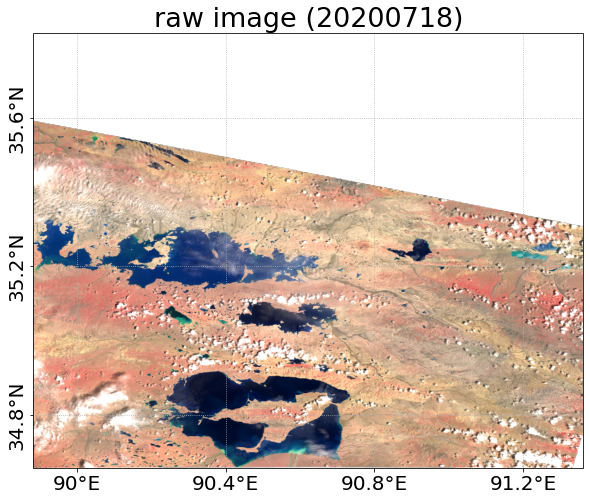

In [18]:
# 原始影像
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
fig = plt.figure(figsize=(12, 8))
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}

# use cartoee to get a map
ax = cartoee.get_map(ref_image, region=re,vis_params=visParams)
cartoee.add_gridlines(ax, interval=[0.4,0.4], linestyle=":", ytick_rotation="vertical")
ax.tick_params(labelsize=20)
ax.set_title(label = 'raw image (20200718)', fontsize=27)

Text(0.5, 1.0, 'reference image (20200819)')

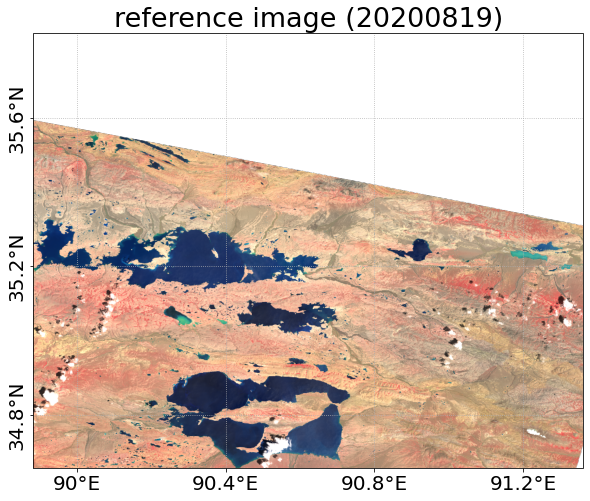

In [19]:
# 参考影像
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

fig = plt.figure(figsize=(12, 8))
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}

# use cartoee to get a map
ax = cartoee.get_map(refer_image, region=re,vis_params=visParams)
cartoee.add_gridlines(ax, interval=[0.4,0.4], linestyle=":", ytick_rotation="vertical")
ax.tick_params(labelsize=20)
ax.set_title(label = 'reference image (20200819)', fontsize=27)

Text(0.5, 1.0, 'classified image (w/o correction)')

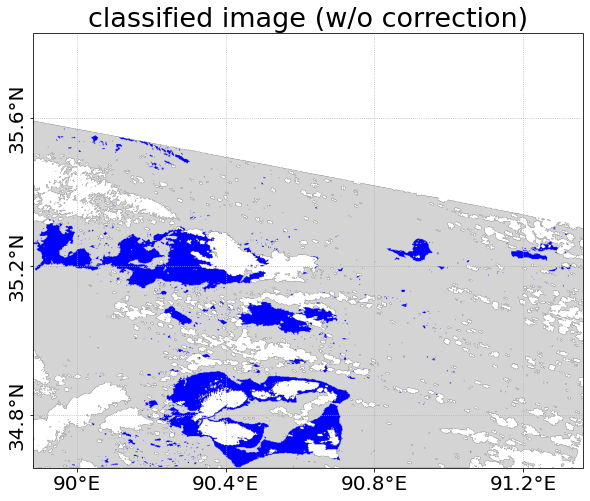

In [20]:
# 分类影像（RF）
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

fig = plt.figure(figsize=(12, 8))
vis = {'palette':['D4D4D4','blue'],'min':0,'max':1}
classify_image = maskSR(water_index(image.clip(roi))).select(bands).classify(trainedClassifier).eq(1).rename('waterclass')

# use cartoee to get a map
ax = cartoee.get_map(classify_image, region=re, vis_params=vis)
cartoee.add_gridlines(ax, interval=[0.4,0.4], linestyle=":", ytick_rotation="vertical")
ax.tick_params(labelsize=20)
ax.set_title(label = 'classified image (w/o correction)', fontsize=27)

Text(0.5, 1.0, 'classified image (with correction)')

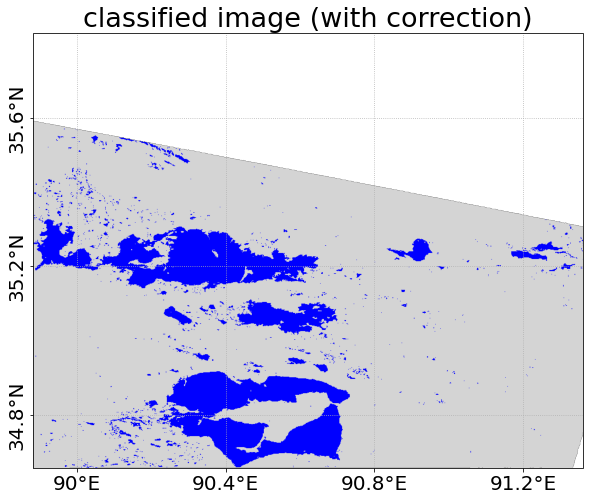

In [21]:
# 分类影像（校正）
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

fig = plt.figure(figsize=(12, 8))
vis = {'palette':['D4D4D4','blue'],'min':0,'max':1}

# use cartoee to get a map
ax = cartoee.get_map(enhance_image, region=re, vis_params=vis)
cartoee.add_gridlines(ax, interval=[0.4,0.4], linestyle=":", ytick_rotation="vertical")
ax.tick_params(labelsize=20)
ax.set_title(label = 'classified image (with correction)', fontsize=27)


In [ ]:
# ## 下载数据
# task = ee.batch.Export.image.toAsset(**{
#     'image': enhance_image,
#     'description': 'enhance_image',
#     'assetId': 'users/311605001111/' + 'enhance_image',
#     'scale': 30,
#     'region': roi,
#     'maxPixels': 1e13,
# })
# task.start()
# ## 加载数据
# enhance = ee.Image('users/311605001111/enhance_image')
# Map.addLayer(enhance.selfMask(),{'palette':['blue']}, 'enhance')

In [ ]:
## 对比
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

fig = plt.figure(figsize=(12, 8))
re = [90.2424, 34.6655,90.327, 34.7328]
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}

refer_img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_139036_20200819').visualize(**visParams)
pw = enhance_image.selfMask().visualize(**{'palette':['blue']})
blend = refer_img.blend(pw)
ax = cartoee.get_map(blend, region=re)
ax.set_title(label = 'Correction results overlay reference images', fontsize=24)